# De-raining + RT-DETR on Custom Images

This notebook demonstrates de-raining preprocessing (SPDNet and DRSformer) followed by object detection using RT-DETR on custom rainy images from the internet or your own files.

In [28]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import requests
from io import BytesIO

# Import utilities
from utils.spdnet_utils import load_spdnet_model, derain_image
from utils.drsformer_utils import load_drsformer_model, derain_image as drsformer_derain
from utils.model_utils import load_model_and_processor
from utils.eval_utils import COCO_CLASS_NAMES

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("✓ All imports successful!")
print(f"CUDA available: {torch.cuda.is_available()}")

✓ All imports successful!
CUDA available: True


## Configuration

In [29]:
# Model paths
SPDNET_MODEL_PATH = r"E:\Python\DLCV\Project\model_spa.pt"
DRSFORMER_MODEL_PATH = r"E:\Python\DLCV\DRSformer\pretrained_models\deraining.pth"
RTDETR_MODEL_PATH = "PekingU/rtdetr_r18vd"

# Device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Detection threshold
CONFIDENCE_THRESHOLD = 0.3

# DRSformer speed optimization
DRSFORMER_MAX_SIZE = 512  # Resize images larger than this before DRSformer (set to None to disable)
DRSFORMER_TILE = 256      # Tile size for DRSformer (smaller = faster)

print(f"SPDNet model: {SPDNET_MODEL_PATH}")
print(f"DRSformer model: {DRSFORMER_MODEL_PATH}")
print(f"RT-DETR model: {RTDETR_MODEL_PATH}")
print(f"Device: {DEVICE}")
print(f"DRSformer max size: {DRSFORMER_MAX_SIZE} (will resize larger images)")
print(f"DRSformer tile size: {DRSFORMER_TILE}")

SPDNet model: E:\Python\DLCV\Project\model_spa.pt
DRSformer model: E:\Python\DLCV\DRSformer\pretrained_models\deraining.pth
RT-DETR model: PekingU/rtdetr_r18vd
Device: cuda
DRSformer max size: 512 (will resize larger images)
DRSformer tile size: 256


## Load Models

In [30]:
# Load SPDNet de-raining model
print("Loading SPDNet model...")
spdnet_model = load_spdnet_model(SPDNET_MODEL_PATH, device=DEVICE, n_feats=32, n_resblocks=3)
print("✓ SPDNet model loaded")

# Load DRSformer de-raining model
print("\nLoading DRSformer model...")
drsformer_model = load_drsformer_model(DRSFORMER_MODEL_PATH, device=DEVICE)
print("✓ DRSformer model loaded")

# Load RT-DETR detection model
print("\nLoading RT-DETR model...")
rtdetr_model, processor = load_model_and_processor(model_name=RTDETR_MODEL_PATH)
rtdetr_model.to(DEVICE)
rtdetr_model.eval()
print("✓ RT-DETR model loaded")

print("\n" + "="*60)
print("ALL MODELS LOADED SUCCESSFULLY!")
print("="*60)

Loading SPDNet model...
SPDNet model loaded from: E:\Python\DLCV\Project\model_spa.pt
✓ SPDNet model loaded

Loading DRSformer model...
SPDNet model loaded from: E:\Python\DLCV\Project\model_spa.pt
✓ SPDNet model loaded

Loading DRSformer model...
DRSformer model loaded from: E:\Python\DLCV\DRSformer\pretrained_models\deraining.pth
✓ DRSformer model loaded

Loading RT-DETR model...
DRSformer model loaded from: E:\Python\DLCV\DRSformer\pretrained_models\deraining.pth
✓ DRSformer model loaded

Loading RT-DETR model...
✓ RT-DETR model loaded

ALL MODELS LOADED SUCCESSFULLY!
✓ RT-DETR model loaded

ALL MODELS LOADED SUCCESSFULLY!


## Load Custom Image

You can load an image in two ways:
1. **From URL**: Paste a URL to a rainy image from the internet
2. **From local file**: Provide a path to an image file on your computer

Loading image from file: C://Users//Mechatronics Lab//Downloads//snow_storm-271_0.jpg
✓ Image loaded: snow_storm-271_0.jpg
  Size: 1280x803 pixels


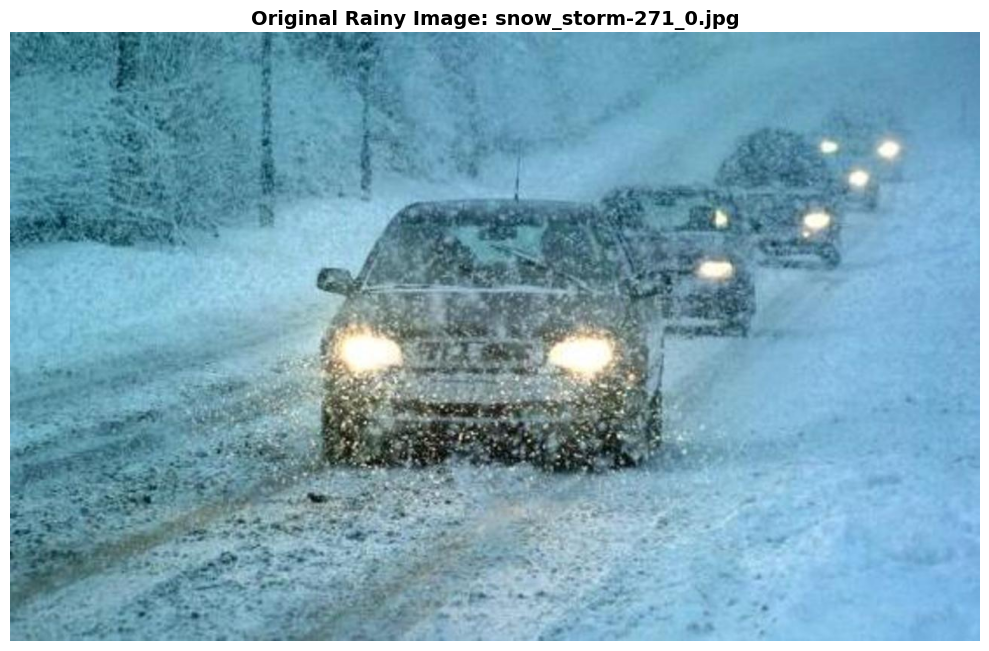

In [31]:
# Option 1: Load from URL
# Uncomment and paste your image URL here:
IMAGE_URL = "https://npr.brightspotcdn.com/legacy/sites/kwgs/files/201410/Heavy_Rain.jpg"

# Option 2: Load from local file
# Uncomment and provide your local image path here:
IMAGE_PATH = "C://Users//Mechatronics Lab//Downloads//snow_storm-271_0.jpg"

# ======== LOAD IMAGE ========
# Choose which method to use:
USE_URL = False  # Set to True to load from URL, False to load from local file

if USE_URL:
    print(f"Loading image from URL: {IMAGE_URL}")
    response = requests.get(IMAGE_URL)
    rainy_image = Image.open(BytesIO(response.content)).convert('RGB')
    image_name = IMAGE_URL.split('/')[-1]
else:
    print(f"Loading image from file: {IMAGE_PATH}")
    rainy_image = Image.open(IMAGE_PATH).convert('RGB')
    image_name = os.path.basename(IMAGE_PATH)

print(f"✓ Image loaded: {image_name}")
print(f"  Size: {rainy_image.size[0]}x{rainy_image.size[1]} pixels")

# Display the original rainy image
plt.figure(figsize=(10, 8))
plt.imshow(rainy_image)
plt.title(f'Original Rainy Image: {image_name}', fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

## Apply De-raining Methods

Applying SPDNet de-raining...
✓ SPDNet de-raining complete

Applying DRSformer de-raining...
  Resizing 1280x803 → 512x321 for speed...
✓ SPDNet de-raining complete

Applying DRSformer de-raining...
  Resizing 1280x803 → 512x321 for speed...
  Resizing back to original 1280x803...
✓ DRSformer de-raining complete
  Resizing back to original 1280x803...
✓ DRSformer de-raining complete


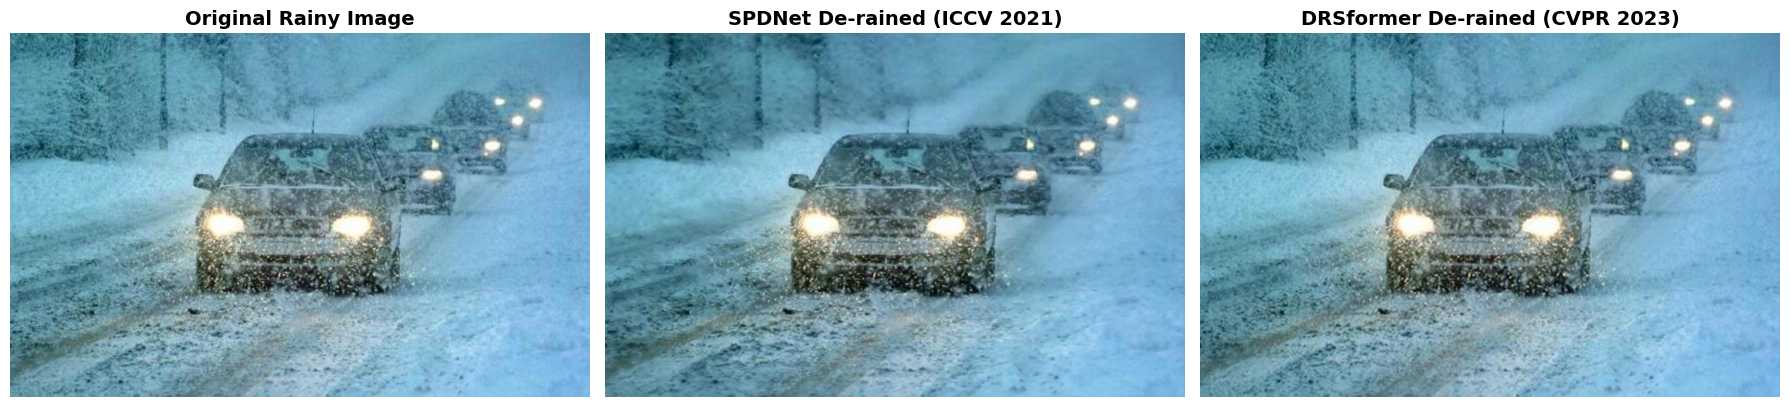


✓ De-raining comparison displayed!


In [32]:
# Apply SPDNet de-raining
print("Applying SPDNet de-raining...")
derained_spdnet = derain_image(rainy_image, spdnet_model, DEVICE)
print(f"✓ SPDNet de-raining complete")

# Apply DRSformer de-raining with resolution optimization
print("\nApplying DRSformer de-raining...")

# Resize for faster processing if image is too large
original_size = rainy_image.size
if DRSFORMER_MAX_SIZE and max(original_size) > DRSFORMER_MAX_SIZE:
    # Calculate new size maintaining aspect ratio
    ratio = DRSFORMER_MAX_SIZE / max(original_size)
    new_size = (int(original_size[0] * ratio), int(original_size[1] * ratio))
    
    print(f"  Resizing {original_size[0]}x{original_size[1]} → {new_size[0]}x{new_size[1]} for speed...")
    rainy_resized = rainy_image.resize(new_size, Image.Resampling.LANCZOS)
    
    # Apply DRSformer on resized image
    derained_small = drsformer_derain(rainy_resized, drsformer_model, DEVICE, tile=DRSFORMER_TILE)
    
    # Resize back to original size
    print(f"  Resizing back to original {original_size[0]}x{original_size[1]}...")
    derained_drsformer = derained_small.resize(original_size, Image.Resampling.LANCZOS)
else:
    # Process at original size
    derained_drsformer = drsformer_derain(rainy_image, drsformer_model, DEVICE, tile=DRSFORMER_TILE)

print(f"✓ DRSformer de-raining complete")

# Visualize de-raining results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(rainy_image)
axes[0].set_title('Original Rainy Image', fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(derained_spdnet)
axes[1].set_title('SPDNet De-rained (ICCV 2021)', fontsize=14, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(derained_drsformer)
axes[2].set_title('DRSformer De-rained (CVPR 2023)', fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("\n✓ De-raining comparison displayed!")

## Run Object Detection

In [33]:
def run_detection(image, model, processor, device, threshold=0.3):
    """Run RT-DETR detection on an image"""
    # Prepare inputs
    inputs = processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Run inference
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Post-process results
    target_sizes = torch.tensor([image.size[::-1]]).to(device)
    results = processor.post_process_object_detection(
        outputs, 
        target_sizes=target_sizes, 
        threshold=threshold
    )[0]
    
    return results

# Run detection on all three versions
print("Running RT-DETR detection...\n")

print("1. Vanilla RT-DETR (no de-raining)...")
rainy_results = run_detection(rainy_image, rtdetr_model, processor, DEVICE, CONFIDENCE_THRESHOLD)
num_rainy = len(rainy_results['boxes'])
print(f"   ✓ Detected {num_rainy} objects")

print("\n2. SPDNet + RT-DETR...")
spdnet_results = run_detection(derained_spdnet, rtdetr_model, processor, DEVICE, CONFIDENCE_THRESHOLD)
num_spdnet = len(spdnet_results['boxes'])
print(f"   ✓ Detected {num_spdnet} objects ({num_spdnet-num_rainy:+d} vs Vanilla)")

print("\n3. DRSformer + RT-DETR...")
drsformer_results = run_detection(derained_drsformer, rtdetr_model, processor, DEVICE, CONFIDENCE_THRESHOLD)
num_drsformer = len(drsformer_results['boxes'])
print(f"   ✓ Detected {num_drsformer} objects ({num_drsformer-num_rainy:+d} vs Vanilla)")

print("\n" + "="*60)
print("DETECTION COMPLETE!")
print("="*60)

Running RT-DETR detection...

1. Vanilla RT-DETR (no de-raining)...
   ✓ Detected 5 objects

2. SPDNet + RT-DETR...
   ✓ Detected 5 objects (+0 vs Vanilla)

3. DRSformer + RT-DETR...
   ✓ Detected 5 objects (+0 vs Vanilla)

DETECTION COMPLETE!
   ✓ Detected 5 objects (+0 vs Vanilla)

3. DRSformer + RT-DETR...
   ✓ Detected 5 objects (+0 vs Vanilla)

DETECTION COMPLETE!


## Visualize Detection Results

✓ Results saved to: custom_derain_comparison_snow_storm-271_0.png


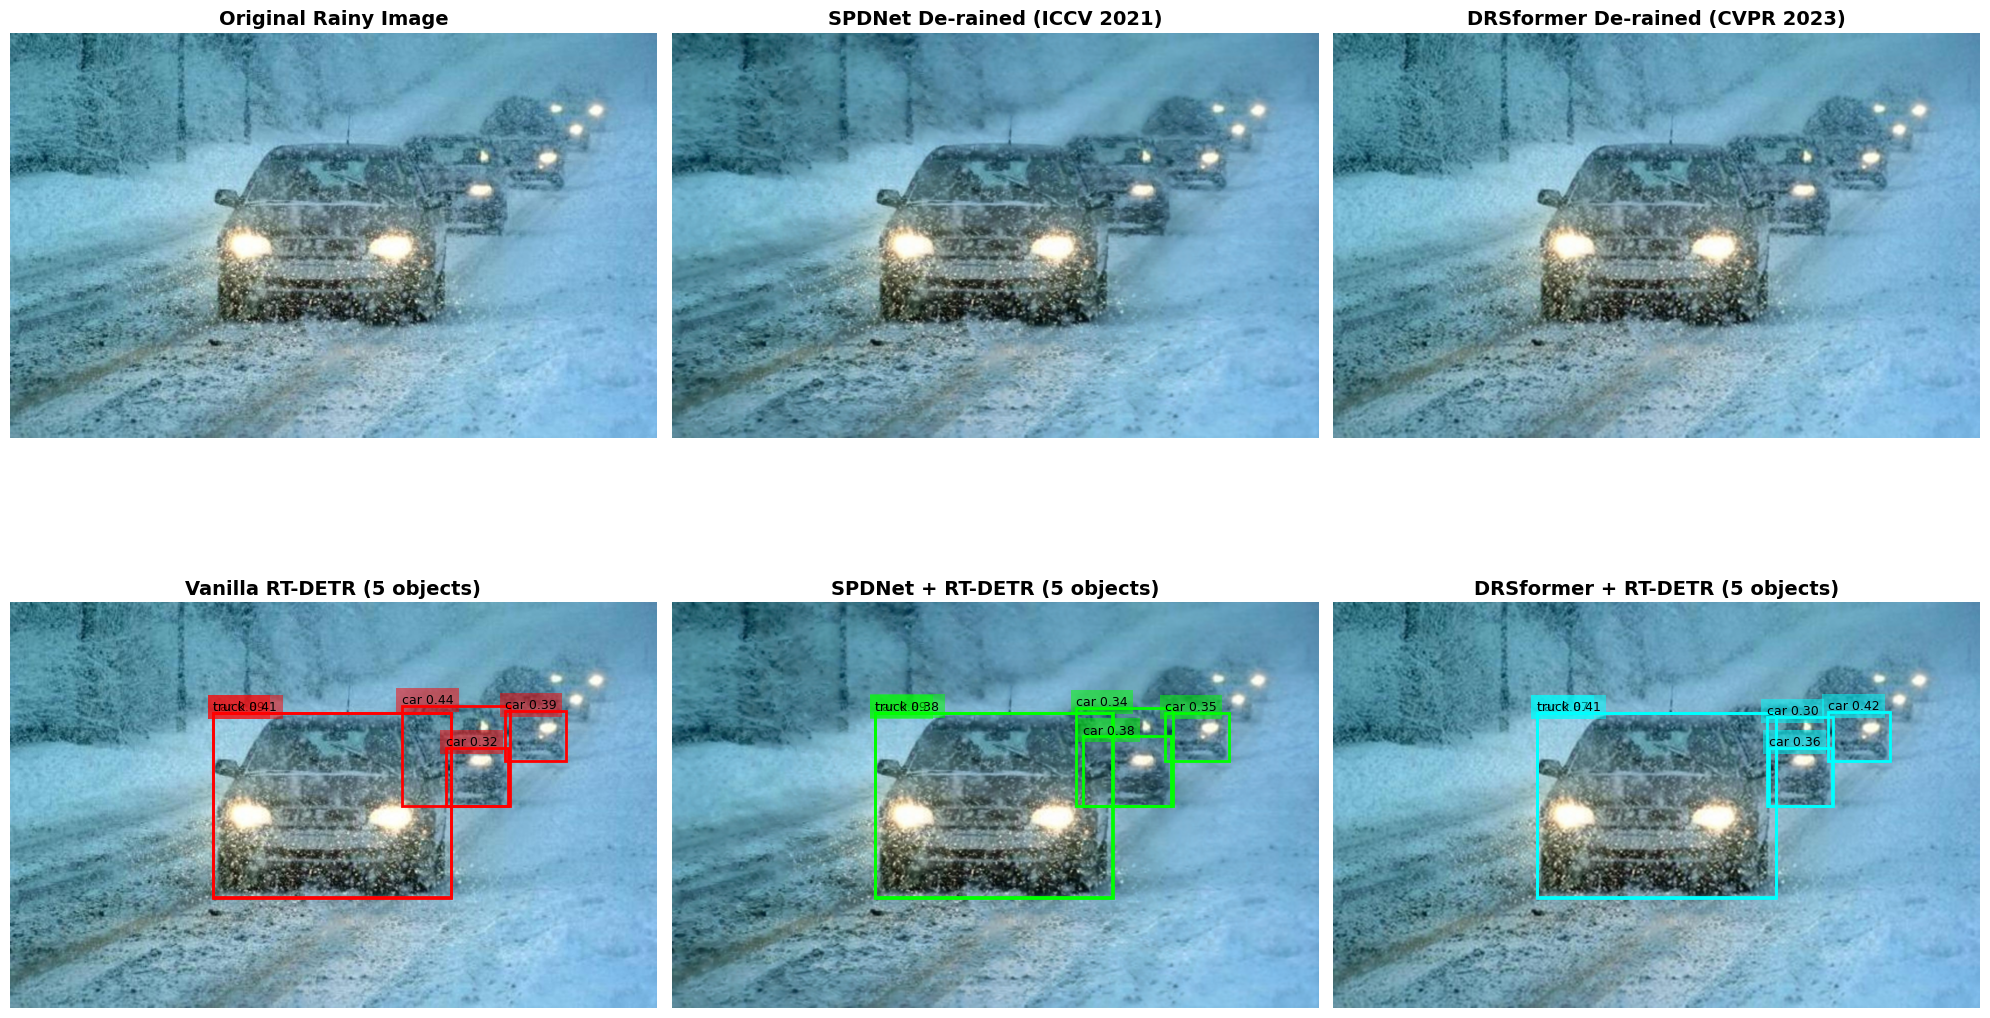

In [34]:
def draw_boxes(ax, img, results, title, box_color='lime'):
    """Draw bounding boxes on image"""
    ax.imshow(img)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.axis('off')
    
    boxes = results['boxes'].cpu().numpy()
    scores = results['scores'].cpu().numpy()
    labels = results['labels'].cpu().numpy()
    
    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1,
            linewidth=2, edgecolor=box_color, facecolor='none'
        )
        ax.add_patch(rect)
        
        class_name = COCO_CLASS_NAMES[int(label)]
        ax.text(
            x1, y1-5, f'{class_name} {score:.2f}',
            bbox=dict(facecolor=box_color, alpha=0.5, edgecolor='none'),
            fontsize=9, color='black'
        )

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 13))

# Top row: De-rained images (without boxes)
axes[0, 0].imshow(rainy_image)
axes[0, 0].set_title('Original Rainy Image', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(derained_spdnet)
axes[0, 1].set_title('SPDNet De-rained (ICCV 2021)', fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

axes[0, 2].imshow(derained_drsformer)
axes[0, 2].set_title('DRSformer De-rained (CVPR 2023)', fontsize=14, fontweight='bold')
axes[0, 2].axis('off')

# Bottom row: Detection results
draw_boxes(axes[1, 0], rainy_image, rainy_results,
           f'Vanilla RT-DETR ({num_rainy} objects)', box_color='red')
draw_boxes(axes[1, 1], derained_spdnet, spdnet_results,
           f'SPDNet + RT-DETR ({num_spdnet} objects)', box_color='lime')
draw_boxes(axes[1, 2], derained_drsformer, drsformer_results,
           f'DRSformer + RT-DETR ({num_drsformer} objects)', box_color='cyan')

plt.tight_layout()

# Save results
output_filename = f'custom_derain_comparison_{image_name.split(".")[0]}.png'
plt.savefig(output_filename, dpi=150, bbox_inches='tight')
print(f"✓ Results saved to: {output_filename}")

plt.show()